In [1]:
import matplotlib.pyplot as plt
import scipy.linalg as linalg
import scipy.stats as stats
import scipy.spatial as spa
import numpy as np
import math

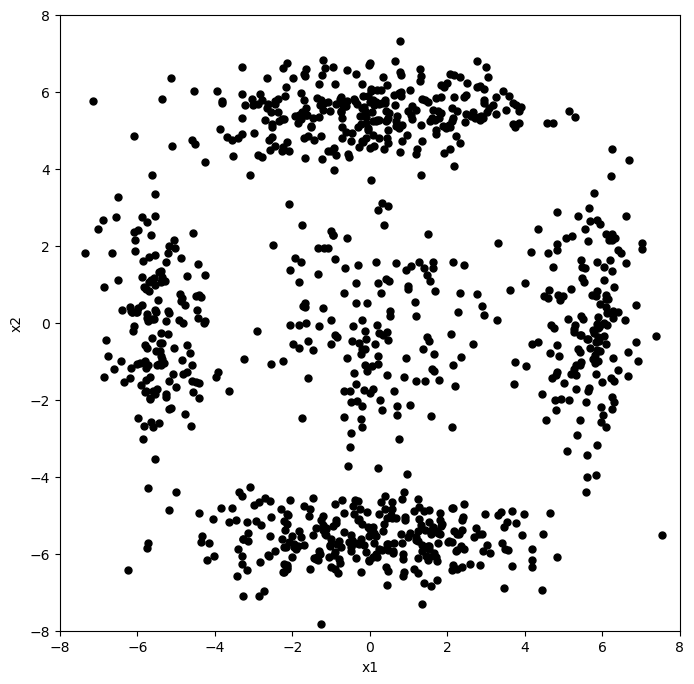

In [2]:
data = np.genfromtxt("hw05_data_set.csv", delimiter = ",")

plt.figure(figsize = (8, 8))
plt.plot(data[:,0], data[:,1], ".", markersize = 10, color = "black")
plt.xlabel("x1")
plt.ylabel("x2")
plt.xlim((-8, 8))
plt.ylim((-8, 8))
plt.show()

In [3]:
K = 5
centroids = np.genfromtxt("hw05_initial_centroids.csv", delimiter = ",")
distances = spa.distance_matrix(centroids, data)
memberships = np.argmin(distances, axis = 0) + 1
priors = [np.mean(memberships == (c + 1)) for c in range(K)]
covariances = np.array([np.matmul((data[memberships == (c + 1)] - centroids[c]).T, (data[memberships == (c + 1)] - centroids[c]))/np.sum(memberships == (c + 1)) for c in range(K)])

In [4]:
def update_soft_label(centroids, priors, covariances, data):
    soft_label = np.zeros((data.shape[0], K))
    
    for i in range(data.shape[0]):
        for j in range(K):
            soft_label[i][j] = (((2 * math.pi)**data.shape[1]) * np.linalg.det(covariances[j]))**(-1/2) * math.exp((-1/2) * (np.matmul((np.matmul((data[i] - centroids[j]), linalg.cho_solve(linalg.cho_factor(covariances[j]), np.eye(2)))),(data[i] - centroids[j]).T))) * priors[j]
    
    soft_label = soft_label / np.reshape(np.sum(soft_label, axis=1),(data.shape[0],1))

    return(soft_label)

def update_parameters(soft_label, data):
    priors = np.sum(soft_label, axis=0)/data.shape[0]
    centroids = np.array([np.matmul(soft_label[:,c].T, data) for c in range(K)]) / np.reshape(np.sum(soft_label, axis=0),(K,1))
    covariances = np.array([np.matmul((data - centroids[c]).T, ((data - centroids[c])* np.reshape(soft_label[:,c], (data.shape[0],1)))) for c in range(K)]) / np.reshape(np.sum(soft_label, axis=0),(K,1,1))
    return(centroids, priors, covariances)

In [5]:
iteration = 1
while True:
    if iteration == 101:
        break
    else:
        soft_label = update_soft_label(centroids, priors, covariances, data)
        centroids, priors, covariances = update_parameters(soft_label, data)
        
    iteration = iteration + 1

In [6]:
print(centroids)

[[ 0.15012647 -0.10601062]
 [ 5.63782309 -0.01720488]
 [-0.06077502 -5.60092697]
 [-0.08487478  5.45469879]
 [-5.4828878  -0.08822559]]


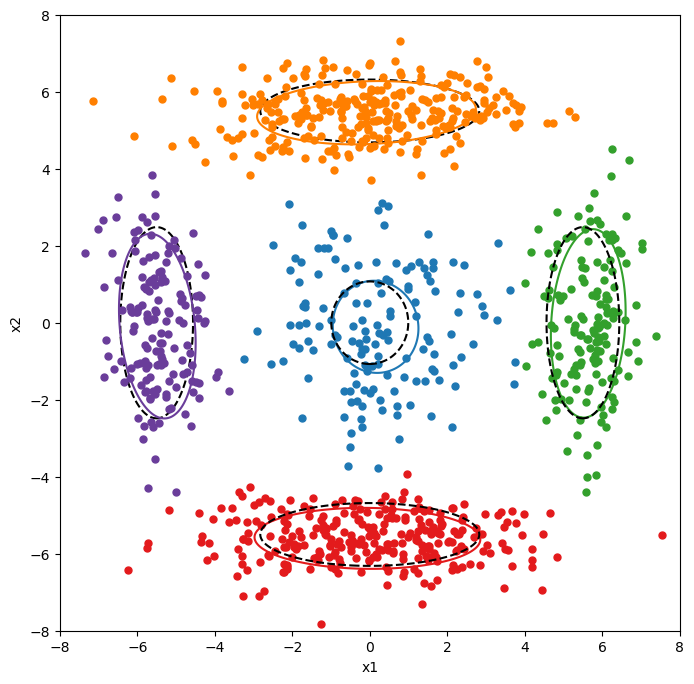

In [8]:
memberships = np.argmax(soft_label, axis = 1)

original_means = np.array([[+0.0, +5.5],
                           [-5.5, +0.0],
                           [+0.0, +0.0],
                           [+5.5, +0.0],
                           [+0.0, -5.5]])
original_covariances = np.array([[[+4.8, +0.0], 
                                  [+0.0, +0.4]],
                                 [[+0.4, +0.0], 
                                  [+0.0, +2.8]],
                                 [[+2.4, +0.0], 
                                  [+0.0, +2.8]],
                                 [[+0.4, +0.0], 
                                  [+0.0, +2.8]],
                                 [[+4.8, +0.0], 
                                  [+0.0, +0.4]],
                                 ])

x1_interval = np.linspace(-8, +8, 1001)
x2_interval = np.linspace(-8, +8, 1001)
x1_grid, x2_grid = np.meshgrid(x1_interval, x2_interval)
X_grid = np.vstack((x1_grid.flatten(), x2_grid.flatten())).T

cluster_colors = np.array(["#1f78b4", "#33a02c", "#e31a1c", "#ff7f00", "#6a3d9a", "#b15928",
                               "#a6cee3", "#b2df8a", "#fb9a99", "#fdbf6f", "#cab2d6", "#ffff99"])

plt.figure(figsize = (8, 8))
for c in range(K):
    plt.plot(data[memberships == c, 0], data[memberships == c, 1], ".", markersize = 10, color = cluster_colors[c])
    D = stats.multivariate_normal.pdf(X_grid, mean = centroids[c,:], cov = covariances[c,:,:])
    D = D.reshape((len(x1_interval), len(x2_interval)))
    plt.contour(x1_grid, x2_grid, D, levels = [0.05], colors = cluster_colors[c], linestyles = "solid")
    D_original = stats.multivariate_normal.pdf(X_grid, mean = original_means[c,:], cov = original_covariances[c,:,:])
    D_original = D_original.reshape((len(x1_interval), len(x2_interval)))
    plt.contour(x1_grid, x2_grid, D_original, levels = [0.05], colors = 'black', linestyles = "dashed")

        
plt.xlabel("x1")
plt.ylabel("x2")
plt.xlim((-8, 8))
plt.ylim((-8, 8))

plt.show()